# Microsimulation of Public Policies Exam

Yann David


In [ ]:
# !pip install OpenFisca-PPDLand == 0.3.3

In [1]:
import matplotlib.pyplot as plt  # For graphics
%matplotlib inline

import inspect
import numpy as np  # linear algebra and math
import pandas as pd  # data frames_

from ppdland import CountryTaxBenefitSystem as PPDLandTaxBenefitSystem
from ppdland.scenarios import PPDLandSurveyScenario, init_single_entity
from ppdland.data import create_input_dataframe

from openfisca_core.model_api import max_
from openfisca_core.rates import marginal_rate

from scipy.optimize import fsolve


%config Completer.use_jedi = False

You work as an economist at the Hipeepee Institute, in the country of Peepeedeeland. Your job consists in producing ex ante evaluations of fiscal reforms in this country. We are in elections period, and several proposals are made by different parties regarding the tax and benefit system, and you have to provide to the public debate elements related to these proposals.

## 1. Explore the current system

You anticipate that you will have to make soon evaluations in small windows of time. In order to be operational at the right moment, you decide to refresh your memory on what the current system looks like.

We create an input dataframe that we will use later on

For the whole exercise the period concerned is `period = 2020`

### 1.1 What are the main components of the existing tax and benefit system ?

__I first start by initialisting the tax benefit system. I then inspect the class with the dir function to get its attributes. I use the get_variables function to retrieve the components of the tax and benefit system.__

In [2]:
tax_benefit_system = PPDLandTaxBenefitSystem()
# dir(tax_benefit_system)
variables = tax_benefit_system.get_variables()
print(variables)

{'disposable_income': <2411936007504_4714623933135629117_variables.disposable_income object at 0x0000023192A4A0A0>, 'income_tax': <2411936007504_4714623933135629117_variables.income_tax object at 0x0000023192A4A1F0>, 'pension': <2411936007504_4714623933135629117_variables.pension object at 0x0000023192A4A070>, 'potential_salary': <2411936007504_4714623933135629117_variables.potential_salary object at 0x000002319296C910>, 'pre_tax_income': <2411936007504_4714623933135629117_variables.pre_tax_income object at 0x000002319296CD90>, 'pre_tax_income_decile': <2411936007504_4714623933135629117_variables.pre_tax_income_decile object at 0x0000023192A8E400>, 'salary': <2411936007504_4714623933135629117_variables.salary object at 0x0000023192A8EA00>}


__I then use the loop as suggested to print the components names and labels, as well as the formula associated to each variable__

In [3]:
for variable_name in variables:
    variable = variables[variable_name]
    try:
        print(variable.name, ":", variable.label)
        if not variable.is_input_variable():
            formula = variable.get_formula(period=2020)
            source_code = inspect.getsourcelines(formula)[0]
            print(''.join(source_code))
        else:
            print('This is an input variable\n')
    except Exception:
        # No formula
        pass
        

disposable_income : Disposable income
    def formula(individu, period):
        salary = individu('salary', period)
        pension = individu('pension', period)
        income_tax = individu('income_tax', period)
        return salary + pension - income_tax

income_tax : Income tax
    def formula(individu, period, parameters):
        salary = individu('salary', period)
        pension = individu('pension', period)
        taxable_income = salary + pension
        tax_scale = parameters(period).tax_scale
        return tax_scale.calc(taxable_income)

pension : Pension
This is an input variable

potential_salary : Potential salary
This is an input variable

pre_tax_income : Pre-tax income
    def formula(individu, period):
        salary = individu('salary', period)
        pension = individu('pension', period)
        return salary + pension

pre_tax_income_decile : Pre-tax income decile
    def formula(individu, period):
        pre_tax_income = individu('pre_tax_income', period)
 

### 1.2 Display the features of the existing income tax (tax base, tax schedule).

__I first start by printing the formula of the tax system. This shows the tax base: *taxable income*__

In [4]:
from ppdland.variables import variables
formula = variables.income_tax().formula
source_code = inspect.getsourcelines(formula)[0]
print(''.join(source_code))

    def formula(individu, period, parameters):
        salary = individu('salary', period)
        pension = individu('pension', period)
        taxable_income = salary + pension
        tax_scale = parameters(period).tax_scale
        return tax_scale.calc(taxable_income)



__I then retrieve the tax schedule from the parameters__

In [5]:
print(tax_benefit_system.parameters(2020).tax_scale)

  - threshold: 0
    rate: 0.05
  - threshold: 1000
    rate: 0.15
  - threshold: 2000
    rate: 0.2
  - threshold: 4000
    rate: 0.3
  - threshold: 8000
    rate: 0.4


### 1.3 Represent budget constraints: draw the net disposable income by pre-tax income for a wage earner. Display also in each graph the first bisector.

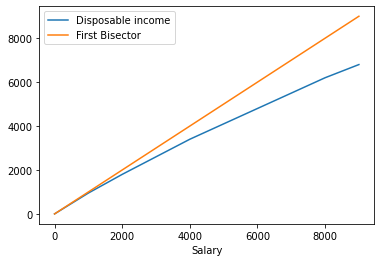

In [6]:
scenario = PPDLandTaxBenefitSystem().new_scenario()
scenario = init_single_entity(
    scenario,
    parent1 = {},
    period = '2020',
    axes = [[
        {
            'count': 100,
            'min': 0,
            'max': 9000,
            'name': 'salary',
            }
        ]],
    )
simulation =  scenario.new_simulation()
income = simulation.calculate('pre_tax_income',period='2020')
disposable_income = simulation.calculate('disposable_income',period='2020')
plt.plot(income,disposable_income, label = 'Disposable income')
plt.plot(income,income, label = 'First Bisector')
plt.xlabel('Salary')
plt.legend()

### 1.4 Compute the labour force participation rate (assumption : no unemployment; i.e. every individual finds a job related to her labour supply).

In [7]:
input_data_frame = create_input_dataframe()
scenario = PPDLandSurveyScenario(
    data = dict(input_data_frame = input_data_frame), 
    tax_benefit_system = PPDLandTaxBenefitSystem(),
    year = 2020,
    )

In [8]:
scenario.tax_benefit_system.variables.keys()

dict_keys(['disposable_income', 'income_tax', 'pension', 'potential_salary', 'pre_tax_income', 'pre_tax_income_decile', 'salary'])

In [9]:
salary = scenario.simulation.calculate('salary', period = 2020)
participation_rate = (
    len(salary[salary>0])/len(input_data_frame)
    
    )
print('Participation rate = {} %'.format(100 * participation_rate))

Participation rate = 72.06 %


### 1.5 Compute and represent graphically the mean disposable income by decile of pre-tax income.

In [10]:
scenario.tax_benefit_system.variables.keys()

dict_keys(['disposable_income', 'income_tax', 'pension', 'potential_salary', 'pre_tax_income', 'pre_tax_income_decile', 'salary'])

There is no weight variable for entity individu nor alternative weights. Switch to unweighted


Text(0, 0.5, 'Mean Disposable Income')

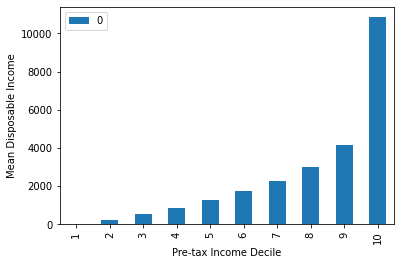

In [11]:
df = scenario.compute_pivot_table(
    aggfunc = 'mean', 
    values = ['disposable_income'], 
    columns = ['pre_tax_income_decile'],
    period = 2020,
    )
df.stack().reset_index().plot(x = 'pre_tax_income_decile', kind = 'bar')
plt.xlabel('Pre-tax Income Decile')
plt.ylabel('Mean Disposable Income')


## 2. Reducing income tax through a new tax bracket


The elections get close, and there are some protests of low-income people. The government wants to reduce taxes for these people by creating a new bracket where the tax rate is zero (i.e. adding a new threshold, between zero and the value of the first threshold of the initial income tax). The threshold of this additive bracket is set at 500 euros.

### 2.1 Represent the change in income tax implied by this policy: produce a graph showing two curves: the income tax before the reform by pre-tax income level for the case of a single individual wage earner, and the income tax after the reform.

* Write the function that build the reform by completing the cell template



In [12]:
from openfisca_core.model_api import *
from ppdland.entities import Individu

THRESHOLD = 500

def add_bracket_reform():    
    tax_benefit_system = PPDLandTaxBenefitSystem()
    def modify_scale(parameters):
        tax_scale = parameters.tax_scale
        shifted_bracket = tax_scale.brackets[0].clone()
        shifted_bracket.threshold.update(period = '2020', value=THRESHOLD) 
        parameters.tax_scale.brackets.insert(1,shifted_bracket)
        tax_scale.brackets[0].rate.update(period = '2020', value=0)
        return parameters

    class reformed_tbs(Reform):
        name = u"Shifting first non-zero bracket threshold to {}".format(THRESHOLD)
        def apply(self):
            self.modify_parameters(modifier_function = modify_scale)

    return reformed_tbs(tax_benefit_system)

In [13]:
baseline_scenario = PPDLandTaxBenefitSystem().new_scenario()
baseline_scenario = init_single_entity(
    baseline_scenario,
    parent1 = {},
    period = '2020',
    axes = [[
        {
            'count': 10000,
            'min': 0,
            'max': 5000,
            'name': 'salary',
            }
        ]],
    )

reformed_tax_benefit_system = add_bracket_reform()
reformed_scenario = reformed_tax_benefit_system.new_scenario()
reformed_scenario = init_single_entity(
    reformed_scenario,
    parent1 = {},
    period = '2020',
    axes = [[
        {
            'count': 10000,
            'min': 0,
            'max': 5000,
            'name': 'salary',
            }
        ]],
    )



In [14]:
reformed_tax_benefit_system.parameters.tax_scale.brackets

[rate:
   2021-01-01: 0.05
   2020-01-01: 0
   2013-01-01: 0.05
 threshold:
   2013-01-01: 0,
 rate:
   2013-01-01: 0.05
 threshold:
   2021-01-01: 0
   2020-01-01: 500
   2013-01-01: 0,
 rate:
   2013-01-01: 0.15
 threshold:
   2013-01-01: 1000,
 rate:
   2013-01-01: 0.2
 threshold:
   2013-01-01: 2000,
 rate:
   2013-01-01: 0.3
 threshold:
   2013-01-01: 4000,
 rate:
   2013-01-01: 0.4
 threshold:
   2013-01-01: 8000]

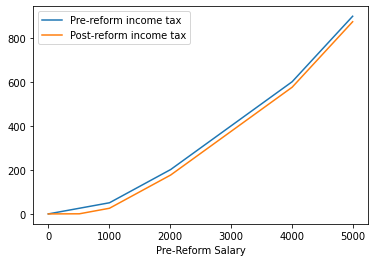

In [15]:
simulation =  baseline_scenario.new_simulation()
simulation_ref =  reformed_scenario.new_simulation()

income = simulation.calculate('salary',period='2020')
income_tax = simulation.calculate('income_tax',period='2020')
income_tax_ref = simulation_ref.calculate('income_tax',period='2020')
plt.plot(income,income_tax, label = 'Pre-reform income tax')
plt.plot(income,income_tax_ref, label = 'Post-reform income tax')

# plt.plot(income,income, label = 'First Bisector')
plt.xlabel('Pre-Reform Salary')
plt.legend()

### 2.2 Compute the cost of this reform (in million euros)

Define a more general `cost` function

In [16]:
def cost():
    reformed_tax_benefit_system = add_bracket_reform()
    scenario = PPDLandSurveyScenario(
        data = dict(input_data_frame = input_data_frame), 
        tax_benefit_system = reformed_tax_benefit_system,
        baseline_tax_benefit_system = PPDLandTaxBenefitSystem(),
        year = 2020,
        )

    amount = -(
        scenario.compute_aggregate('income_tax', period = 2020) - 
        scenario.compute_aggregate('income_tax', period = 2020, use_baseline = True)
        )
    return amount / 1e6

In [17]:
print(f'The cost of this reform is {cost()} million euros')

There is no weight variable for entity individu nor alternative weights. Switch to unweighted
There is no weight variable for entity individu nor alternative weights. Switch to unweighted
The cost of this reform is 0.635776 million euros


### 2.3 Compute the redistributive effects of the reform: draw a graph showing the mean variation in disposable income by decile of pre-reform pre-tax income

There is no weight variable for entity individu nor alternative weights. Switch to unweighted


<AxesSubplot:xlabel='pre_tax_income_decile'>

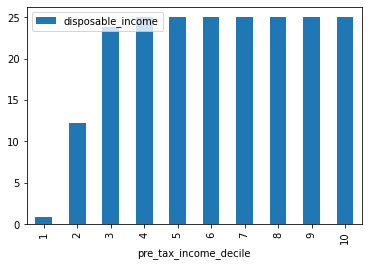

In [18]:
reformed_tax_benefit_system = add_bracket_reform()
scenario = PPDLandSurveyScenario(
    data = dict(input_data_frame = input_data_frame), 
    tax_benefit_system = reformed_tax_benefit_system,
    baseline_tax_benefit_system = PPDLandTaxBenefitSystem(),
    year = 2020,
    )
# disposable_income difference after - before by decile 
df = scenario.compute_pivot_table(
     aggfunc = 'mean', 
    values = ['disposable_income'], 
    columns = ['pre_tax_income_decile'],
    difference = True,
    period = 2020,
    )
df.transpose().reset_index().plot(x = 'pre_tax_income_decile', kind = 'bar')

### 2.4 Interpret the results

The reform proposed by the government fails at targetting the desired population. Indeed, low-income people benefit the least from the tax reform. Furthermore, the entire population benefit from the reduction. As a consequence, the fourth bracket to the tenth benefit from a 25€ tax reduction, wheread the three first brackets benefit from less tax reduction. The cost of the reform is therefore unproperly spent to meet the initial ambitions of the government. 

### 2.5 Your boss asks you whether this figure is the only way to represent the redistributive effects of this reform. What would you answer him about other potential representations, the underlying trade-off between these different possibilities, and information you would need to draw such alternative representations?

Another way to represent the redistributive effect of the reform would be to measure the income change in proportion to initial income. One may therefore observe that the reform proportionally benefits more low-income brackets than richer ones. However, this relative approch may fail at capturing the absolute character of poverty. 

## 3. Making the reform budget neutral

Following the publication of your work, some citizens complain that there will be a deficit, and that we do not know in the end who will pay for it. Under pressure, the government decides to increase the top marginal tax rate.

### 3.1 Compute the top-marginal tax rate which makes the reform budget neutral.  

In [19]:
def build_reform(top_marginal_rate):    
    tax_benefit_system = add_bracket_reform()
    def modify_top_rate(parameters):
        tax_scale = parameters.tax_scale
        tax_scale.brackets[-1].rate.update(period = '2020', value=top_marginal_rate)
        return parameters

    class reformed_tbs(Reform):
        name = u"Setting the top marginal rate to {}".format(top_marginal_rate)
        def apply(self):
            self.modify_parameters(modifier_function = modify_top_rate)

    return reformed_tbs(tax_benefit_system)

In [20]:
def cost(top_marginal_rate):
    top_marginal_rate = float(top_marginal_rate)
    reformed_tax_benefit_system = build_reform(top_marginal_rate)
    scenario = PPDLandSurveyScenario(
        data = dict(input_data_frame = input_data_frame), 
        tax_benefit_system = reformed_tax_benefit_system,
        baseline_tax_benefit_system = PPDLandTaxBenefitSystem(),
        year = 2020
        )

    amount = -(
        scenario.compute_aggregate('income_tax', period = 2020) - 
        scenario.compute_aggregate('income_tax', period = 2020, use_baseline = True)
        )
    return amount / 1e6

In [21]:
cost(.5)
first_guess = 0.5
budget_balancing_top_marginal_rate = fsolve(cost, first_guess)  # you can use fsolve
print(f"The budget-balancing top marginal tax rate is {budget_balancing_top_marginal_rate}") 

There is no weight variable for entity individu nor alternative weights. Switch to unweighted
There is no weight variable for entity individu nor alternative weights. Switch to unweighted
There is no weight variable for entity individu nor alternative weights. Switch to unweighted
There is no weight variable for entity individu nor alternative weights. Switch to unweighted
There is no weight variable for entity individu nor alternative weights. Switch to unweighted
There is no weight variable for entity individu nor alternative weights. Switch to unweighted
There is no weight variable for entity individu nor alternative weights. Switch to unweighted
There is no weight variable for entity individu nor alternative weights. Switch to unweighted
There is no weight variable for entity individu nor alternative weights. Switch to unweighted
There is no weight variable for entity individu nor alternative weights. Switch to unweighted
There is no weight variable for entity individu nor alternat

### 3.2 Represent the change in income tax implied by this policy: produce a graph showing two curves: the income tax before the reform by pre-tax income level for the case of a single individual wage earner, and the income tax after the reform (reform = the new bracket + the new top tax rate).

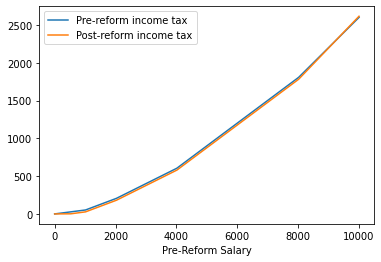

In [22]:
baseline_scenario = PPDLandTaxBenefitSystem().new_scenario()
baseline_scenario = init_single_entity(
    baseline_scenario,
    parent1 = {},
    period = '2020',
    axes = [[
        {
            'count': 10000,
            'min': 0,
            'max': 10000,
            'name': 'salary',
            }
        ]],
    )

reformed_tax_benefit_system = build_reform(0.42)
reformed_scenario = reformed_tax_benefit_system.new_scenario()
reformed_scenario = init_single_entity(
    reformed_scenario,
    parent1 = {},
    period = '2020',
    axes = [[
        {
            'count': 10000,
            'min': 0,
            'max': 10000,
            'name': 'salary',
            }
        ]],
    )

simulation =  baseline_scenario.new_simulation()
simulation_ref =  reformed_scenario.new_simulation()

income = simulation.calculate('salary',period='2020')
income_tax = simulation.calculate('income_tax',period='2020')
income_tax_ref = simulation_ref.calculate('income_tax',period='2020')
plt.plot(income,income_tax, label = 'Pre-reform income tax')
plt.plot(income,income_tax_ref, label = 'Post-reform income tax')

# plt.plot(income,income, label = 'First Bisector')
plt.xlabel('Pre-Reform Salary')
plt.legend()

### 3.3 Compute the redistributive effects of the reform: draw a graph showing the mean variation in disposable income by decile of pre-reform pre-tax income.

There is no weight variable for entity individu nor alternative weights. Switch to unweighted


<AxesSubplot:xlabel='pre_tax_income_decile'>

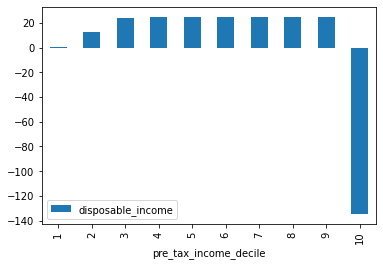

In [23]:
reformed_tax_benefit_system = build_reform(0.42)
scenario = PPDLandSurveyScenario(
    data = dict(input_data_frame = input_data_frame), 
    tax_benefit_system = reformed_tax_benefit_system,
    baseline_tax_benefit_system = PPDLandTaxBenefitSystem(),
    year = 2020,
    )
# disposable_income difference after - before by decile 
df = scenario.compute_pivot_table(
     aggfunc = 'mean', 
    values = ['disposable_income'], 
    columns = ['pre_tax_income_decile'],
    difference = True,
    period = 2020,
    )
df.transpose().reset_index().plot(x = 'pre_tax_income_decile', kind = 'bar')

## 4. Reducing income tax through a tax reduction

In this context of elections, the main opposition party, which is a little bit more bureaucratic, proposes a different income tax reform. The tax schedule is unchanged. However, every individual whose income tax is lower than 25 euros will benefit from a tax reduction equals to 18.75-0.75*(income tax before reduction). Again, the plan is to increase the top-marginal tax rate to make this reform budget neutral.

### 4.1 Code this reform and compute the top-marginal tax rate which makes this reform budget neutral.

In [24]:
def build_reform_with_tax_reduction(top_marginal_rate):    
    tax_benefit_system = PPDLandTaxBenefitSystem()

    def modify_top_rate(parameters):
        tax_scale = parameters.tax_scale
        tax_scale.brackets[-1].rate.update(period = '2020', value=top_marginal_rate)
        return parameters
    
    class income_tax(Variable):
        def formula(individu, period, parameters):
            salary = individu('salary', period)
            pension = individu('pension', period)
            taxable_income = salary + pension
            tax_scale = parameters(period).tax_scale
            income_tax_before_reduction = tax_scale.calc(taxable_income)
            tax_reduction = (income_tax_before_reduction<=25)*(18.75-0.75*(income_tax_before_reduction)) 
            income_tax_after_reduction = max_(0, income_tax_before_reduction - tax_reduction)
            return income_tax_after_reduction
    
    class reformed_tbs(Reform):
        name = u"Adding a tax deduction and modify top margianl rate"

        def apply(self):
            self.modify_parameters(modifier_function = modify_top_rate)
            self.update_variable(income_tax)

    return reformed_tbs(tax_benefit_system)

In [25]:
def cost(top_marginal_rate):
    top_marginal_rate = float(top_marginal_rate)
    reformed_tax_benefit_system = build_reform_with_tax_reduction(top_marginal_rate = top_marginal_rate)
    scenario = PPDLandSurveyScenario(
        data = dict(input_data_frame = input_data_frame), 
        tax_benefit_system = build_reform_with_tax_reduction(top_marginal_rate),
        baseline_tax_benefit_system = PPDLandTaxBenefitSystem(),
        year = 2020,
        )
    amount = (
        scenario.compute_aggregate('income_tax', period = 2020) - 
        scenario.compute_aggregate('income_tax', period = 2020, use_baseline = True)
        )
    return amount / 1e6


first_guess = 0.5
budget_balancing_top_marginal_rate = fsolve(cost,first_guess)
print(f"The budget-balancing top marginal tax rate is {budget_balancing_top_marginal_rate}") 

There is no weight variable for entity individu nor alternative weights. Switch to unweighted
There is no weight variable for entity individu nor alternative weights. Switch to unweighted
There is no weight variable for entity individu nor alternative weights. Switch to unweighted
There is no weight variable for entity individu nor alternative weights. Switch to unweighted
There is no weight variable for entity individu nor alternative weights. Switch to unweighted
There is no weight variable for entity individu nor alternative weights. Switch to unweighted
There is no weight variable for entity individu nor alternative weights. Switch to unweighted
There is no weight variable for entity individu nor alternative weights. Switch to unweighted
There is no weight variable for entity individu nor alternative weights. Switch to unweighted
There is no weight variable for entity individu nor alternative weights. Switch to unweighted
There is no weight variable for entity individu nor alternat

### 4.2 Represent the change in income tax implied by this policy: produce a graph showing two curves: the income tax before the reform by pre-tax income level for the case of a single individual wage earner, and the income tax after the reform.

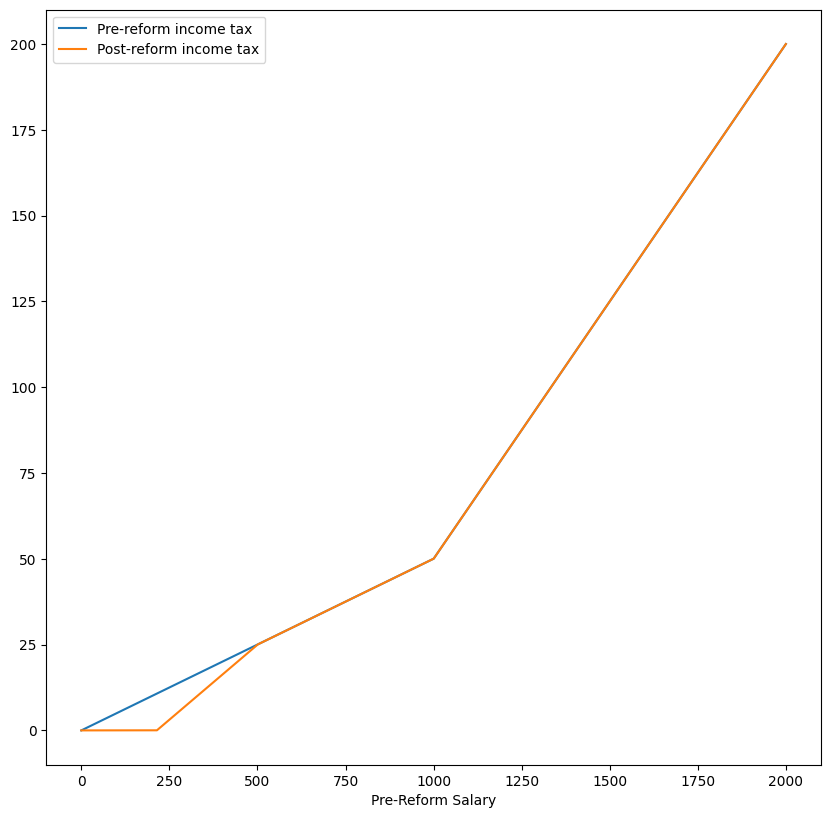

In [26]:
baseline_scenario = PPDLandTaxBenefitSystem().new_scenario()
baseline_scenario = init_single_entity(
    baseline_scenario,
    parent1 = {},
    period = '2020',
    axes = [[
        {
            'count': 10000,
            'min': 0,
            'max': 2000,
            'name': 'salary',
            }
        ]],
    )
reformed_tax_benefit_system = build_reform_with_tax_reduction(budget_balancing_top_marginal_rate[0])
reformed_scenario = reformed_tax_benefit_system.new_scenario()
reformed_scenario = init_single_entity(
    reformed_scenario,
    parent1 = {},
    period = '2020',
    axes = [[
        {
            'count': 10000,
            'min': 0,
            'max': 2000,
            'name': 'salary',
            }
        ]],
    )

simulation =  baseline_scenario.new_simulation()
simulation_ref =  reformed_scenario.new_simulation()

income = simulation.calculate('salary',period='2020')
income_tax = simulation.calculate('income_tax',period='2020')
income_tax_ref = simulation_ref.calculate('income_tax',period='2020')
plt.figure(figsize=(10,10), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(income,income_tax, label = 'Pre-reform income tax')
plt.plot(income,income_tax_ref, label = 'Post-reform income tax')

# plt.plot(income,income, label = 'First Bisector')
plt.xlabel('Pre-Reform Salary')
plt.legend()


### 4.3 Which feature this reform allows to reach, compared to the first reform?

This reform allows to target the population of low-income individuals, while keeping income tax level constant for other deciles except for the upper one which observes a slight increase in the upper bracket marginal rate. 

### 4.4 Compute the redistributive effects of the reform: draw a graph showing the mean variation in disposable income by decile of pre-reform pre-tax income.

There is no weight variable for entity individu nor alternative weights. Switch to unweighted


<AxesSubplot:xlabel='pre_tax_income_decile'>

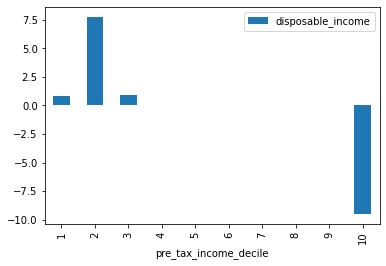

In [27]:
reformed_tax_benefit_system = build_reform_with_tax_reduction(budget_balancing_top_marginal_rate[0])
scenario = PPDLandSurveyScenario(
    data = dict(input_data_frame = input_data_frame), 
    tax_benefit_system = reformed_tax_benefit_system,
    baseline_tax_benefit_system = PPDLandTaxBenefitSystem(),
    year = 2020,
    )
# disposable_income difference after - before by decile 
df = scenario.compute_pivot_table(
     aggfunc = 'mean', 
    values = ['disposable_income'], 
    columns = ['pre_tax_income_decile'],
    difference = True,
    period = 2020,
    )
df.transpose().reset_index().plot(x = 'pre_tax_income_decile', kind = 'bar')

### 4.5 Do you see some « drawback » related to this reform?

This reform successfuly targets the low-income population, but disproportionately favors people located in the second income-decile. However, one could argue that individuals in the first income decile are the ones that should benefit the more from the reform as they are the more in need. As the reform is proportional to income, it cannot improve importantly the welfare of low-income individuals. Only transfers could do so. 

Furthermore, the reform may be highly criticised by the top 10% which are absorbing the burden of the reform.

### 4.6 What are the limits of these results overall?

The main limitation of these results is that they do not account for the behavioural responses from individuals. Indeed, a change in the tax schedule may trigger changes in the working behaviour.

## 5. Labour supply behavioural responses along the intensive margin

This proposal of tax reduction seems to get more and more attention in the public debate, and your boss asks you to improve your simulations. Now, you are asked to take into account behavioural responses along the intensive margin, taking an elasticity of 0.4. Reminder: this elasticity is the variation in percentage of hours of work when the marginal net of tax rate (i.e. 1 - marginal tax rate) increases by 1%. Here, we implicitly assume that hourly wage is constant for a given individual, so that the variation in % of hours of work is equal to the variation in % of total wage.

### 5.1 Explain in plain English in which direction behavioural responses in this setting will go.

In this setting, we expect that the number of hours worked (the intensive margin) increases by 0.4% when the marginal net of tax rate increases by 1%. This implies that low-income individuals whom marginal net of tax rate increases with the reform should work more, while the top 10% individuals should work less.

### 5.2 Compute the variation in % in the mass of wages due to these behavioural responses

In [28]:
def intensive_margin_extension(top_marginal_rate):    
    tax_benefit_system = build_reform_with_tax_reduction(top_marginal_rate)

    class initial_marginal_net_of_tax_rate(Variable):         
        definition_period = YEAR
        entity = Individu
        value_type = float

        def formula(individu, period, parameters):
            tax_scale = parameters(period).tax_scale            
            salary = individu('salary', period)
            delta = 1
            initial_marginal_net_of_tax_rate = 1 - (
                (tax_scale.calc(salary + 1) - tax_scale.calc(salary)) / delta
                )
            return initial_marginal_net_of_tax_rate

    class delta_marginal_net_of_tax_rate(Variable):         
        definition_period = YEAR
        entity = Individu
        value_type = float

        def formula(individu, period, parameters):
            tax_scale = parameters(period).tax_scale
            
            def compute_income_tax_after_reduction(salary_):
                income_tax_before_reduction = tax_scale.calc(salary_)
                tax_reduction = (income_tax_before_reduction<=25)*(18.75-0.75*(income_tax_before_reduction))
                income_tax_after_reduction = max_(0,income_tax_before_reduction - tax_reduction)  
                return income_tax_after_reduction
            
            salary = individu('salary', period)
            delta = 1
            final_marginal_net_of_tax_rate = (
                1 
                - (compute_income_tax_after_reduction(salary + 1) - compute_income_tax_after_reduction(salary)) / delta
                )
            initial_marginal_net_of_tax_rate = individu("initial_marginal_net_of_tax_rate", period)
            delta_marginal_net_of_tax_rate = final_marginal_net_of_tax_rate - initial_marginal_net_of_tax_rate  
            return delta_marginal_net_of_tax_rate
        
    class adjusted_salary(Variable):         
        definition_period = YEAR
        entity = Individu
        value_type = float
        
        def formula_2020(individu, period):
            salary = individu('salary', period)  # salary is salary before behavioral response
            delta_marginal_net_of_tax_rate = individu('delta_marginal_net_of_tax_rate', period)
            initial_marginal_net_of_tax_rate = individu('initial_marginal_net_of_tax_rate', period)
            elasticity = .4
            adjusted_salary = (
                salary 
                * ( 1 - elasticity * delta_marginal_net_of_tax_rate/initial_marginal_net_of_tax_rate
                    )
                )
            return adjusted_salary 
        
    class income_tax(Variable):         
        definition_period = YEAR
        entity = Individu
        value_type = float
    
        def formula(individu, period, parameters):
            salary = individu('adjusted_salary',period)
            pension = individu('pension', period)
            taxable_income = salary + pension
            tax_scale = parameters(period).tax_scale
            income_tax_before_reduction = tax_scale.calc(taxable_income)
            tax_reduction = (income_tax_before_reduction<=25)*(18.75-0.75*(income_tax_before_reduction))
            income_tax_after_reduction = max_(0, income_tax_before_reduction - tax_reduction)
            return income_tax_after_reduction
            
    class disposable_income(Variable):
        definition_period = YEAR
        entity = Individu
        value_type = float
        
        def formula_2020(individu, period):
            salary = individu('adjusted_salary',period)
            pension = individu('pension',period)
            income_tax = individu('income_tax',period)
            return salary + pension - income_tax
        
    class reformed_tbs(Reform):
        name = "Reformed tax benefit system"
        
        def apply(self):
            self.add_variable(initial_marginal_net_of_tax_rate)
            self.add_variable(delta_marginal_net_of_tax_rate)
            self.add_variable(adjusted_salary)
            self.update_variable(disposable_income)
            self.update_variable(income_tax)
            
    return reformed_tbs(tax_benefit_system)

In [29]:
reformed_tax_benefit_system = intensive_margin_extension(top_marginal_rate = budget_balancing_top_marginal_rate[0])
scenario = PPDLandSurveyScenario(
    data = dict(input_data_frame = input_data_frame), 
    tax_benefit_system = reformed_tax_benefit_system,
    baseline_tax_benefit_system = PPDLandTaxBenefitSystem(),
    year = 2020,
    )
adjusted_salary = scenario.compute_aggregate('adjusted_salary', period = 2020)
baseline_salary = scenario.compute_aggregate('salary', period = 2020, use_baseline = True)
wages_variation = (adjusted_salary - baseline_salary)/baseline_salary*100
print(wages_variation)

There is no weight variable for entity individu nor alternative weights. Switch to unweighted
There is no weight variable for entity individu nor alternative weights. Switch to unweighted
0.015611934941262007


### 5.3 Compute the cost of the reform after taking into account these behavioural responses

In [30]:
def cost(top_marginal_rate):
    reformed_tax_benefit_system = intensive_margin_extension(top_marginal_rate = top_marginal_rate)
    scenario = PPDLandSurveyScenario(
        data = dict(input_data_frame = input_data_frame), 
        tax_benefit_system = reformed_tax_benefit_system,
        baseline_tax_benefit_system = PPDLandTaxBenefitSystem(),
        year = 2020,
        )
    amount = (
        scenario.compute_aggregate('income_tax', period = 2020) - 
        scenario.compute_aggregate('income_tax', period = 2020, use_baseline = True)
        )
    return amount / 1e6

print(f'The cost of the reform is {cost(budget_balancing_top_marginal_rate[0])} million euros')


There is no weight variable for entity individu nor alternative weights. Switch to unweighted
There is no weight variable for entity individu nor alternative weights. Switch to unweighted
The cost of the reform is 0.001474 million euros


### 5.4 Compute the new labour force participation rate.

In [31]:
reformed_tax_benefit_system = intensive_margin_extension(top_marginal_rate = budget_balancing_top_marginal_rate[0])
scenario = PPDLandSurveyScenario(
    data = dict(input_data_frame = input_data_frame), 
    tax_benefit_system = reformed_tax_benefit_system,
    baseline_tax_benefit_system = PPDLandTaxBenefitSystem(),
    year = 2020,
    )
adjusted_salary = scenario.simulation.calculate('adjusted_salary', period = 2020)
participation_rate = (
    len(adjusted_salary[adjusted_salary>0])/len(input_data_frame)
    
    )
print('Participation rate = {} %'.format(100 * participation_rate))

Participation rate = 72.06 %


### 5.5 Compute the redistributive effects of the reform: draw a graph showing the mean variation in disposable income by decile of pre-reform pre-tax income.

There is no weight variable for entity individu nor alternative weights. Switch to unweighted


<AxesSubplot:xlabel='pre_tax_income_decile'>

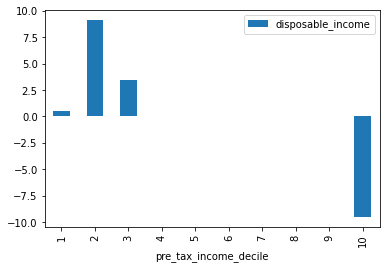

In [32]:
reformed_tax_benefit_system = intensive_margin_extension(budget_balancing_top_marginal_rate[0])
scenario = PPDLandSurveyScenario(
    data = dict(input_data_frame = input_data_frame), 
    tax_benefit_system = reformed_tax_benefit_system,
    baseline_tax_benefit_system = PPDLandTaxBenefitSystem(),
    year = 2020,
    )
# disposable_income difference after - before by decile 
df = scenario.compute_pivot_table(
     aggfunc = 'mean', 
    values = ['disposable_income'], 
    columns = ['pre_tax_income_decile'],
    difference = True,
    period = 2020,
    )
df.transpose().reset_index().plot(x = 'pre_tax_income_decile', kind = 'bar')

### 5.6 Comment all these results.

The reform produces an overall welfare improvement, as aggregate wages increase by 15%, while the cost of the reform is much smaller than the initial plan of the government. As expected, the participation rate does not increase, as we simulate the intensive margin variation. Finally, we observe that the redistributive effect of the reform mostly benefit the second and third income deciles. The first income decile is not very affected by the reform. 

## 6. Labour supply behavioural responses along the extensive margin

Now, your boss says you that behavioural responses are, according to the recent papers, mainly along the extensive margin. Your boss asks you to evaluate the impact of this reform (the one of the opposition party) by taking into account only responses at the extensive margin, taking an elasticity of 0.6. Reminder: this elasticity is equal to the variation of the probability to work when the difference of disposable income between working and not working increases by 1%. For simplicity, we assume that the initial probability to work is the same for all individuals and equal to the share of workers in the labour force.

### 6.1 What do you think about this strategy (the extensive margin is the most relevant) regarding the existing literature?

According to Chetty et al. in their 2013 paper, the extensive margin effect is smaller than the intensive margin response ; in contrast to what was previously reported in the literature. As a consequence, one should be very cautious with the interpreation of the following results in comparison to the previous ones. 

### 6.2 Explain in plain English in which direction behavioural responses in this setting will go.

In this setting, we expect non-wage earners (with potential salary in the first three deciles) to enter into the job market as a response to the tax incentive. We also expect that the reform will affect negatively the probability of top-decile earners to enter the job market as the difference in disposable income between working and not working will reduce. The question is therefore to understand how the two effects of job creation at the lower deciles and job market withdrawal at the top-decile will aggregate to make the reform budget neutral.

### 6.3 Implement the reform that takes into account behavioural responses. Produce summary statistics on the variation in participation: the share of former non-participants who participate now (if some) and the share of former participant who still participate (if some)

In [33]:
def participation_extension(top_marginal_rate):    
    tax_benefit_system = build_reform_with_tax_reduction(top_marginal_rate)

    class disposable_income_participation_variation(Variable):         
        definition_period = YEAR
        entity = Individu
        value_type = float

        def formula(individu, period, parameters):
            # If an individual starts working, she is supposed to earn her potential salary 
            # it is nonzero only for potential and actual wage earners
            # salary is nonzero only for actual wage earners
            potential_salary = individu('potential_salary', period)
            
            def compute_income_tax_after_reduction(salary_):
                income_tax_before_reduction = parameters(period).tax_scale.calc(salary_)
                tax_reduction = (income_tax_before_reduction<=25)*(18.75-0.75*(income_tax_before_reduction))
                income_tax_after_reduction = max_(0,income_tax_before_reduction - tax_reduction)  
                return income_tax_after_reduction
            
            disposable_income_participation_variation = where(
                potential_salary > 0,
                compute_income_tax_after_reduction(potential_salary),
                0
                )
            return disposable_income_participation_variation
        
    class participation_adjusted_salary(Variable):
        definition_period = YEAR
        entity = Individu
        value_type = float
        
        def formula_2020(individu, period, parameters):
            np.random.seed(seed = 42)
            salary = individu('salary', period)
            potential_salary = individu('potential_salary', period)

            
            disposable_income_participation_variation = individu('disposable_income_participation_variation', period)
            pre_reform_disposable_income_participation_variation = where(
                potential_salary > 0,
                parameters(period).tax_scale.calc(potential_salary),
                0
                )
            eta = .6
            delta_DIPV_over_DIPV = where(
                potential_salary > 0,
                (disposable_income_participation_variation-pre_reform_disposable_income_participation_variation)/pre_reform_disposable_income_participation_variation,
                0,
                )
            initial_participation_probability = sum(salary > 0) / sum(potential_salary > 0)
            delta_participation_probability = eta * delta_DIPV_over_DIPV * initial_participation_probability
            new_participation_probability = initial_participation_probability + delta_participation_probability
            probability_still_in_work_among_initial_workers = (salary>0)*new_participation_probability
            still_in_work = (
                (salary > 0)
                * (np.random.uniform(size = len(salary)) < probability_still_in_work_among_initial_workers)
                )
            print("Share of initial workers still working: ", sum(still_in_work) / sum(salary > 0))

            probability_newly_employed =  (salary==0)*new_participation_probability
            newly_employed = (
                (salary == 0) * (potential_salary > 0)
                * (np.random.uniform(size = len((salary == 0) * (potential_salary > 0))) < probability_newly_employed)
                )
            print("Share of initial non-participants entering into participation: ", sum(newly_employed) / sum((salary == 0) * (potential_salary > 0)))            

            
            return where(
                still_in_work + newly_employed,  # + is or for boolean
                potential_salary, 
                0
                )
        
    class income_tax(Variable):         
        definition_period = YEAR
        entity = Individu
        value_type = float
    
        def formula(individu, period, parameters):
            salary = individu('participation_adjusted_salary',period)
            pension = individu('pension', period)
            taxable_income = salary + pension
            tax_scale = parameters(period).tax_scale
            income_tax_before_reduction = tax_scale.calc(taxable_income)
            tax_reduction = (income_tax_before_reduction<=25)*(18.75-0.75*(income_tax_before_reduction))
            income_tax_after_reduction = max_(0, income_tax_before_reduction - tax_reduction)
            return income_tax_after_reduction
                            

    class disposable_income(Variable):
        definition_period = YEAR
        entity = Individu
        value_type = float
        
        def formula_2020(individu, period):
            salary = individu('participation_adjusted_salary',period)
            pension = individu('pension',period)
            income_tax = individu('income_tax',period)
            return salary + pension - income_tax       
        
    class reformed_tbs(Reform):
        name = "Reformed tax benefit system"
        
        def apply(self):
            self.add_variable(disposable_income_participation_variation)
            self.add_variable(participation_adjusted_salary)
            self.update_variable(income_tax)
            self.update_variable(disposable_income)
            
    return reformed_tbs(tax_benefit_system)

In [34]:
participation_adjusted_reformed_tax_benefit_system = participation_extension(budget_balancing_top_marginal_rate[0])
scenario = PPDLandSurveyScenario(
    data = dict(input_data_frame = input_data_frame),
    tax_benefit_system = participation_adjusted_reformed_tax_benefit_system,
    baseline_tax_benefit_system = PPDLandTaxBenefitSystem(),
    year = 2020,
    )

In [36]:
salary = scenario.calculate_variable("salary", period = 2020)
potential_salary = scenario.calculate_variable("potential_salary", period = 2020)
participation_adjusted_salary = scenario.calculate_variable("participation_adjusted_salary", period = 2020)
print("Share of initial non-participants entering into participation: {} %".format(
    100 * sum((potential_salary>0)&(salary==0)&(participation_adjusted_salary>0))/sum((potential_salary>0)&(salary==0))
    ))
print("Share of initial participants who still participate:  {} %".format(
    100 * sum((potential_salary>0)&(salary>0)&(participation_adjusted_salary>0))/sum((potential_salary>0)&(salary>0))
    ))

Share of initial non-participants entering into participation: 83.21291967700807 %
Share of initial participants who still participate:  82.75973725599037 %


### 6.4 Compute the cost of the reform after taking into account these behavioural responses.

In [52]:
def cost(top_marginal_rate):
    reformed_tax_benefit_system = participation_extension(top_marginal_rate)
    scenario = PPDLandSurveyScenario(
        data = dict(input_data_frame = input_data_frame), 
        tax_benefit_system = reformed_tax_benefit_system,
        baseline_tax_benefit_system = PPDLandTaxBenefitSystem(),
        year = 2020,
        )
    amount = (
        scenario.compute_aggregate('income_tax', period = 2020) - 
        scenario.compute_aggregate('income_tax', period = 2020, use_baseline = True)
        )
    return amount / 1e6

print(f'The cost of the reform is {cost(budget_balancing_top_marginal_rate[0])} million euros')


There is no weight variable for entity individu nor alternative weights. Switch to unweighted
<ipython-input-34-548d9e5f8ba0>:48: RuntimeWarning: invalid value encountered in true_divide
  (disposable_income_participation_variation-pre_reform_disposable_income_participation_variation)/pre_reform_disposable_income_participation_variation,
Share of initial workers still working:  0.8275973725599037
There is no weight variable for entity individu nor alternative weights. Switch to unweighted
Share of initial non-participants entering into participation:  0.8321291967700808
The cost of the reform is 0.169102 million euros


### 6.5 Compute the new labour force participation rate.

In [54]:
participation_rate = (
    sum((potential_salary>0) & (salary>0))/len(input_data_frame)
    )
print('Initial participation rate = {} %'.format(100 * participation_rate))

Initial participation rate = 72.06 %


In [55]:
participation_rate = (
    sum((participation_adjusted_salary>0))/len(input_data_frame)
    )
print('Participation rate = {} %'.format(100 * participation_rate))

Participation rate = 66.16333333333333 %


### 6.6 Compute the redistributive effects of the reform: draw a graph showing the mean variation in disposable income by decile of pre-reform pre-tax income.

There is no weight variable for entity individu nor alternative weights. Switch to unweighted
<ipython-input-34-548d9e5f8ba0>:48: RuntimeWarning: invalid value encountered in true_divide
  (disposable_income_participation_variation-pre_reform_disposable_income_participation_variation)/pre_reform_disposable_income_participation_variation,
Share of initial workers still working:  0.8275973725599037
Share of initial non-participants entering into participation:  0.8321291967700808


<AxesSubplot:xlabel='pre_tax_income_decile'>

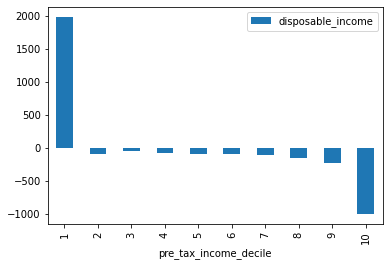

In [56]:
reformed_tax_benefit_system = participation_extension(budget_balancing_top_marginal_rate[0])
scenario = PPDLandSurveyScenario(
    data = dict(input_data_frame = input_data_frame), 
    tax_benefit_system = reformed_tax_benefit_system,
    baseline_tax_benefit_system = PPDLandTaxBenefitSystem(),
    year = 2020,
    )
# disposable_income difference after - before by decile 
df = scenario.compute_pivot_table(
     aggfunc = 'mean', 
    values = ['disposable_income'], 
    columns = ['pre_tax_income_decile'],
    difference = True,
    period = 2020,
    )
df.transpose().reset_index().plot(x = 'pre_tax_income_decile', kind = 'bar')

### 6.7 Comment all these results.

In the analysis, we observe that the reform has important effects on the job market configuration. Indeed, it incentivises many non participants to enter the job market (83% of them), but it also reduces incentivises for higher deciles workers to remain in the job market (17% of them drop). At the equilibrium in this simulation, 66% of adults are in the labour force which contrasts with the 72% in the initial situation. As a consequence, the reform is not budget neutral and costs 169 thousand euros. Furthermore, the burden of the reform is mostly borne by the top-ten decile, but only the first decile benefit from it. This is a different picture from the one provided with the intensive margin response to the reform. Here, only the poorer individuals are benefiting from the tax, and the cost is distributed across the upper deciles in proportion to income level.  

# 7. About the future

### Your boss says that now, you have to publish all your work, because journalists are getting crazy for not having the results of your evaluation. However, he suggests that you need to have together a meeting to talk about other ways to microsimulate the impacts of reforms of these kinds, in order to anticipate for future work.


The main way to expand microsimulation of reforms of this kind would be to add time dimension to it. This is referred as dynamic microsimulation in the literature. This approach allows to simulate demographic changes and to add this layer to the ex-ante evaluation of a reform. This offers a unique outlook at the intertemporal dimension of agents decisions. Most specifically in this context, it would allow to look at the long-run equilibrium in the labour supply due to the reform. This information can improve policy budgetting and provide with a more precise vision on the consequences of a reform.